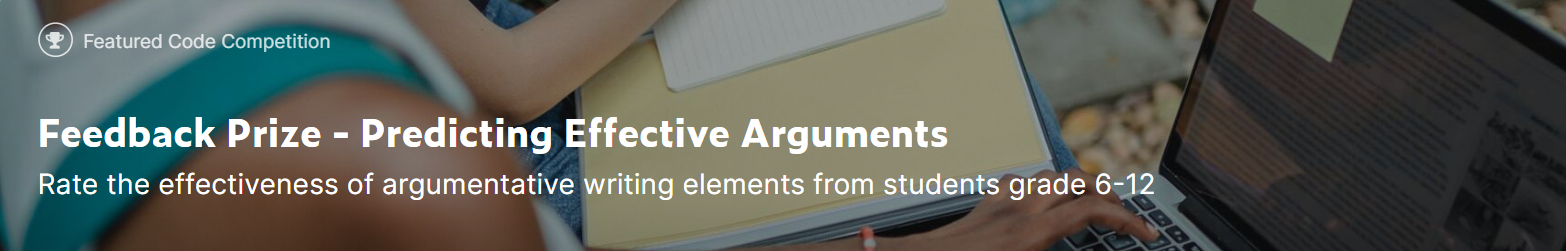

## Background:
### Competition goal: 
The goal of this competition is to classify argumentative elements in student writing as "effective," "adequate" or "ineffective". This competition will comprise two tracks. 
>- The first track will be a traditional track in which accuracy of classification will be the only metric used for success. Success on this track will be updated on the Kaggle leaderboard. Prize money for the accuracy-only, “Leaderboard Prize” track will be $25,000. 

>- The second track will measure computational efficiency in which efficiency is determined using a combination of accuracy and the speed at which models are able to generate these predictions. Prize money for the computational, “Efficiency Prize” track will be $30,000.

### Evaluation:
You must submit a CSV file with each discourse element's discourse_id and a predicted probability for each of the three effectiveness ratings. The order of the rows does not matter. 

#### First track - accuracy:
The first track of this competition focuses on accuracy of classification. Submissions for this track are evaluated using multi-class logarithmic loss. Each row in the dataset has been labeled with one true effectiveness label. For each row, you must submit the predicted probabilities that the product belongs to each quality label. The formula is:

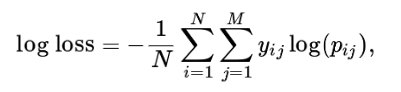

where N is the number of rows in the test set, M is the number of class labels, log is the natural logarithm, yij is 1 if observation i is in class j and 0 otherwise, and pij is the predicted probability that observation i belongs to class j. The logarithm in this case is the natural logarithm.

The submitted probabilities for a given discourse element are not required to sum to one: they are rescaled prior to being scored, each row being divided by the row sum. In order to avoid the extremes of the  function, predicted probabilities are replaced with .

#### Second track - efficiency score:
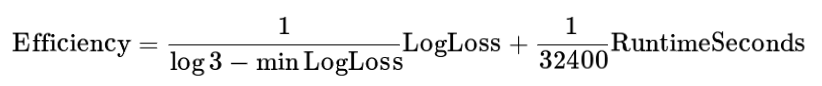

where LogLoss is the submission's score on the main competition metric, min LogLoss is the minimum  of all submissions on the Private Leaderboard, and RuntimeSeconds is the number of seconds it takes for the submission to be evaluated. The objective is to minimize the efficiency score.

### Data description:
The dataset presented here contains argumentative essays written by U.S students in grades 6-12. These essays were annotated by expert raters for discourse elements commonly found in argumentative writing:
>- Lead - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis
>- Position - an opinion or conclusion on the main question
>- Claim - a claim that supports the position
>- Counterclaim - a claim that refutes another claim or gives an opposing reason to the position
>- Rebuttal - a claim that refutes a counterclaim
>- Evidence - ideas or examples that support claims, counterclaims, or rebuttals.
>- Concluding Statement - a concluding statement that restates the claims

Argumentation Annotation Scheme and Descriptions: https://docs.google.com/document/d/1G51Ulb0i-nKCRQSs4p4ujauy4wjAJOae/edit

Your task is to predict the quality rating of each discourse element. Human readers rated each rhetorical or argumentative element, in order of increasing quality, as one of:
>- Ineffective
>- Adequate
>- Effective

#### Training Data:
The training set consist of a .csv file containing the annotated discourse elements each essay, including the quality ratings, together with .txt files containing the full text of each essay. It is important to note that some parts of the essays will be unannotated (i.e., they do not fit into one of the classifications above) and they will lack a quality rating. We do not include the unannotated parts in train.csv.

train.csv - Contains the annotated discourse elements for all essays in the train set.
>- discourse_id - ID code for discourse element
>- essay_id - ID code for essay response. This ID code corresponds to the name of the full-text file in the train/ folder.
>- discourse_text - Text of discourse element.
>- discourse_type - Class label of discourse element.
>- discourse_type_num - Enumerated class label of discourse element .
>- discourse_effectiveness - Quality rating of discourse element, the target.

Example Test Data
To help you author submission code, we include a few example instances selected from the test set. When you submit your notebook for scoring, this example data will be replaced by the actual test data, including the sample_submission.csv file.
>- test/ - A folder containing an example essay from the test set. The actual test set comprises about 3,000 essays in a format similar to the training set essays. The test set essays are distinct from the training set essays.
>- test.csv - Annotations for the test set essays, containing all of the fields of train.csv except the target, discourse_effectiveness.
>- sample_submission.csv - A sample submission file in the correct format. See the Evaluation page for more details.

### Train notebook: https://www.kaggle.com/code/arunamenon/feedback-prize-complete-eda-modeling-deberta

## Import packages

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import time
import re
from tqdm import tqdm
tqdm.pandas()
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from sklearn import model_selection as sk_model_selection
import random
import math
import gc
import warnings
warnings.filterwarnings("ignore")
import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=SEED)

## Load data

In [ ]:
test = pd.read_csv('../input/feedback-prize-effectiveness/test.csv')
sample_submission = pd.read_csv('../input/feedback-prize-effectiveness/sample_submission.csv')

## Modelling

In [ ]:
def get_essay_text(sample_essay_id, train_flag = 'train'):
    filepath = '../input/feedback-prize-effectiveness/'
    with open(filepath + f'{train_flag}/' + sample_essay_id+'.txt','r') as f:
        sample_essay_text = f.read()
    return sample_essay_text

test['essay_text'] = test['essay_id'].apply(lambda x: get_essay_text(x, 'test'))

In [ ]:
test['text'] = test['discourse_text'] + '[SEP]' + test['discourse_type'] + '[SEP]' + test['essay_text']
display(test.head())
# Create dummy labels
test['discourse_effectiveness'] = 'Adequate'

In [ ]:
class CFG:
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model='../input/deberta-v3-large-feedback-prize'
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=2
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=2
    fc_dropout=0.2
    target_size=3
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=SEED
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    train=True

In [ ]:
OUTPUT_DIR = './'
tokenizer = AutoTokenizer.from_pretrained('../input/tokenizer-deberta-v3-large',
                           add_special_tokens=True,
                           max_length=CFG.max_len,
                           padding="max_length",
                           return_offsets_mapping=False, truncation=True)
CFG.tokenizer = tokenizer

In [ ]:
# Assign max length as 512 since most discourse texts are lower in word length than 512
CFG.max_len = 512

In [ ]:
# ====================================================
# Dataset
# ====================================================
label_num_dict = {'Adequate':0, 'Ineffective':1, 'Effective':2}
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False, truncation=True)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TestDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['discourse_effectiveness'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(label_num_dict[self.labels[item]], dtype=torch.float)
        return inputs, label

In [ ]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [ ]:
# Reference: https://www.kaggle.com/code/debarshichanda/pytorch-feedback-deberta-v3-baseline
        
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(self.cfg.model)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(self.cfg.model)
        else:
            self.model = AutoModel.from_config(self.config)
        self.pooler = MeanPooling()
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self.sig = nn.Sigmoid()

    def forward(self, ids, mask):
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.sig(self.fc(out))
        return outputs

In [ ]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    for step, (inputs, labels) in enumerate(test_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        ids = inputs['input_ids'].to(device, dtype = torch.long)
        mask = inputs['attention_mask'].to(device, dtype = torch.long)
        labels = labels.to(device, dtype = torch.long)
        with torch.no_grad():
            y_preds = model(ids, mask)
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [ ]:
test_dataset = TestDataset(CFG, test)

test_loader = DataLoader(test_dataset,
                          batch_size=CFG.batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)

In [ ]:
# ====================================================
# model & optimizer
# ====================================================
model = CustomModel(CFG, config_path='../input/deberta-v3-large-feedback-prize/config.pth', pretrained=False)
state = torch.load('../input/deberta-v3-large-feedback-prize/microsoft-deberta-v3-large_best.pth', 
                         map_location=torch.device('cpu'))
model.load_state_dict(state['model'])
model.to(device)

def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
         'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters

optimizer_parameters = get_optimizer_params(model,
                                            encoder_lr=CFG.encoder_lr, 
                                            decoder_lr=CFG.decoder_lr,
                                            weight_decay=CFG.weight_decay)
optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)

# ====================================================
# scheduler
# ====================================================
def get_scheduler(cfg, optimizer, num_train_steps):
    if cfg.scheduler == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
        )
    elif cfg.scheduler == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
        )
    return scheduler

In [ ]:
num_test_steps = int(len(test) / CFG.batch_size * CFG.epochs)
scheduler = get_scheduler(CFG, optimizer, num_test_steps)
num_test_steps

In [ ]:
predictions = inference_fn(test_loader, model, device)
torch.cuda.empty_cache()
gc.collect()

In [ ]:
label_num_dict

In [ ]:
predictions[0]

In [ ]:
submission_df = sample_submission.copy()
submission_df['Ineffective'] = predictions[:,1]
submission_df['Adequate'] = predictions[:,0]
submission_df['Effective'] = predictions[:,2]
submission_df

In [ ]:
submission_df.to_csv('submission.csv',index=False)